In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 25

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/10 [==>...........................] - ETA: 26s - loss: 3.2575 - accuracy: 0.0234
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 4s 135ms/step - loss: 3.2602 - accuracy: 0.0321 - val_loss: 3.2023 - val_accuracy: 0.0390
Epoch 2/1000
 1/10 [==>...........................] - ETA: 0s - loss: 3.2516 - accuracy: 0.0391
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 0s 24ms/step - loss: 3.2234 - accuracy: 0.0451 - val_loss: 3.1950 - val_accuracy: 0.0338
Epoch 3/1000
 1/10 [==>...........................] - ETA: 0s - loss: 3.2384 - accuracy: 0.0703
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
10/10 [==============================] - 0s 23ms/step - loss: 3.2074 - accuracy: 0.0589 - val_loss: 3.1886 - val_accuracy: 0.0675
Epoch 4/1000
 1/10 [==>...........................] - ETA: 0s - loss: 3.2060 - accuracy: 0.0

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 4ms/step - loss: 1.2559 - accuracy: 0.6208


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 411ms/step
[3.8816903e-02 9.3684974e-04 6.4682811e-03 1.2802269e-04 1.6623785e-01
 8.0738240e-04 1.3934646e-04 9.1044036e-05 2.2144586e-01 2.6589132e-07
 2.8855653e-05 3.2381818e-04 2.6589321e-02 5.4652034e-03 6.6554951e-03
 3.3594880e-04 1.1461703e-06 8.7660501e-06 3.2488268e-02 2.7765680e-02
 2.5733053e-07 2.5853760e-05 3.7263904e-05 2.9982836e-04 4.6490240e-01]
24


# Confusion matrix

13/13 [==============================] - 0s 3ms/step


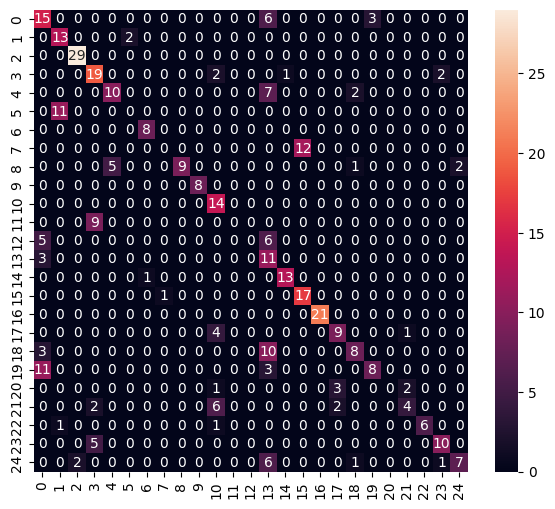

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.62      0.49        24
           1       0.52      0.87      0.65        15
           2       0.94      1.00      0.97        29
           3       0.54      0.79      0.64        24
           4       0.67      0.53      0.59        19
           5       0.00      0.00      0.00        11
           6       0.89      1.00      0.94         8
           7       0.00      0.00      0.00        12
           8       1.00      0.53      0.69        17
           9       1.00      1.00      1.00         8
          10       0.50      1.00      0.67        14
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        11
          13       0.22      0.79      0.35        14
          14       0.93      0.93      0.93        14
          15       0.59      0.94      0.72        18
          16       1.00      1.00      1.00        21
     

C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Cathy\AppData\Local\Temp\tmpnboer1ks\assets


INFO:tensorflow:Assets written to: C:\Users\Cathy\AppData\Local\Temp\tmpnboer1ks\assets


7468

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.8816951e-02 9.3684945e-04 6.4682718e-03 1.2802269e-04 1.6623786e-01
 8.0738170e-04 1.3934622e-04 9.1044043e-05 2.2144577e-01 2.6589132e-07
 2.8855684e-05 3.2381850e-04 2.6589328e-02 5.4652099e-03 6.6554830e-03
 3.3594886e-04 1.1461684e-06 8.7660510e-06 3.2488283e-02 2.7765702e-02
 2.5733078e-07 2.5853737e-05 3.7263875e-05 2.9982871e-04 4.6490246e-01]
24
